In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Processing results
import json

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Processing
from sklearn.preprocessing import StandardScaler

# Data imputation
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

<IPython.core.display.Javascript object>

In [3]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [4]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [5]:
def get_xgboost_importances(scores, importance_type="gain"):
    tree_importances = []

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances_dict = (
            model.get_booster().get_score(importance_type=importance_type).copy()
        )
        tree_importances.append(
            pd.DataFrame(
                importances_dict.values(),
                index=importances_dict.keys(),
                columns=[f"Value - {index}"],
            ).T
        )

    df_importances = pd.concat(tree_importances)

    return df_importances

<IPython.core.display.Javascript object>

In [6]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [7]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [8]:
df = pd.read_csv("../../../../data/processed/partner_iv/cement-shipping.csv")

<IPython.core.display.Javascript object>

In [9]:
df.columns

Index(['Date', 'SO3', 'Cl-', 'Blaine', 'ph2oimm', 'Initial Setting Time',
       'Soundness', 'flow', 'CS2', 'CS28', 'residuo 24 micron', 'R_wp',
       'Alite_M3 C3S M3', 'Alite_M1 C3S M1', 'Alite_Sum C3S tot',
       'Ratio_M1 (rapporto M1/M3)', 'C3S_CS (taglia dei cristalliti C3S)',
       'Belite_beta', 'C3A cub', 'C3A_ortho', 'C3A tot', 'C4AF', 'CaO',
       'Ca(OH)2', 'Calce libera', 'Periclasio (MgO)', 'Quartz', 'K2SO4',
       'Langbeinite – MgK2(SO4)2', 'Aphthitalite – (K,Na)3(SO4)2', 'Gesso',
       'Emiidrato', 'Anidrite', 'Calcite – CaCO3', 'SO3_XRD', 'CO2_XRD',
       'cem_type_CEM B', 'cem_type_CEM C'],
      dtype='object')

<IPython.core.display.Javascript object>

# Chemical + Mineralogical Features

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [12]:
df_copy = df.copy()
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "ph2oimm",  # Maybe pH of the immersion liquid | pH (acidity or alkalinity)
        "Initial Setting Time",
        "flow",  # Maybe flow table test
        "residuo 24 micron",  # Maybe the residue left after passing the material through a sieve
        "R_wp",  # Maybe water to powder ratio
        "CS2",  # 2-day Compressive Strength
        "Soundness",
        # Removing One-Hot encoding variables
        "cem_type_CEM B",
        "cem_type_CEM C",
        "Alite_M3 C3S M3",  # Partial form of C3S
        "Alite_M1 C3S M1",  # Partial form of C3S
        "C3A cub",  # Partial form of C3A
        "C3A_ortho",  # Partial form of C3A
        "Ratio_M1 (rapporto M1/M3)",  # Related to partial forms of Alite
        "C3S_CS (taglia dei cristalliti C3S)",
        "Belite_beta",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

In [13]:
df_copy.columns

Index(['Date', 'SO3', 'Cl-', 'CS28', 'Alite_Sum C3S tot', 'C3A tot', 'C4AF',
       'CaO', 'Ca(OH)2', 'Calce libera', 'Periclasio (MgO)', 'Quartz', 'K2SO4',
       'Langbeinite – MgK2(SO4)2', 'Aphthitalite – (K,Na)3(SO4)2', 'Gesso',
       'Emiidrato', 'Anidrite', 'Calcite – CaCO3', 'SO3_XRD', 'CO2_XRD'],
      dtype='object')

<IPython.core.display.Javascript object>

# 1. Linear Regression

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [14]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## Repeated KFold Cross validation

In [15]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -3.089 (0.035)
MAE: -2.397 (0.031)
MAPE: -0.050 (0.001)
R2: 0.782 (0.005)


******
[TEST]
******
RMSE: -3.160 (0.137)
MAE: -2.462 (0.114)
MAPE: -0.051 (0.002)
R2: 0.770 (0.021)




<IPython.core.display.Javascript object>

In [16]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features              Model Cross Validation RMSE Test  \
                                                                     mean   
0  Chemical + Mineralogical  Linear Regression   Repeated KFold  3.160258   

             MAE Test           MAPE Test             R2 Test            
        std      mean       std      mean       std      mean       std  
0  0.136703  2.461795  0.114055  0.051314  0.002357  0.769903  0.021082

<IPython.core.display.Javascript object>

https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

In [17]:
df_coefs, df_bias = get_linreg_df_importances(scores)

<IPython.core.display.Javascript object>

In [18]:
df_coefs.mean().sort_values().to_frame(name="Coefficient").style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,Coefficient
Calcite – CaCO3,-5.559727
SO3_XRD,-2.360602
Calce libera,-2.319333
Cl-,-1.605376
Periclasio (MgO),-0.552963
C3A tot,-0.424645
Quartz,-0.225822
C4AF,-0.204231
Alite_Sum C3S tot,0.352777
"Aphthitalite – (K,Na)3(SO4)2",0.483748


<IPython.core.display.Javascript object>

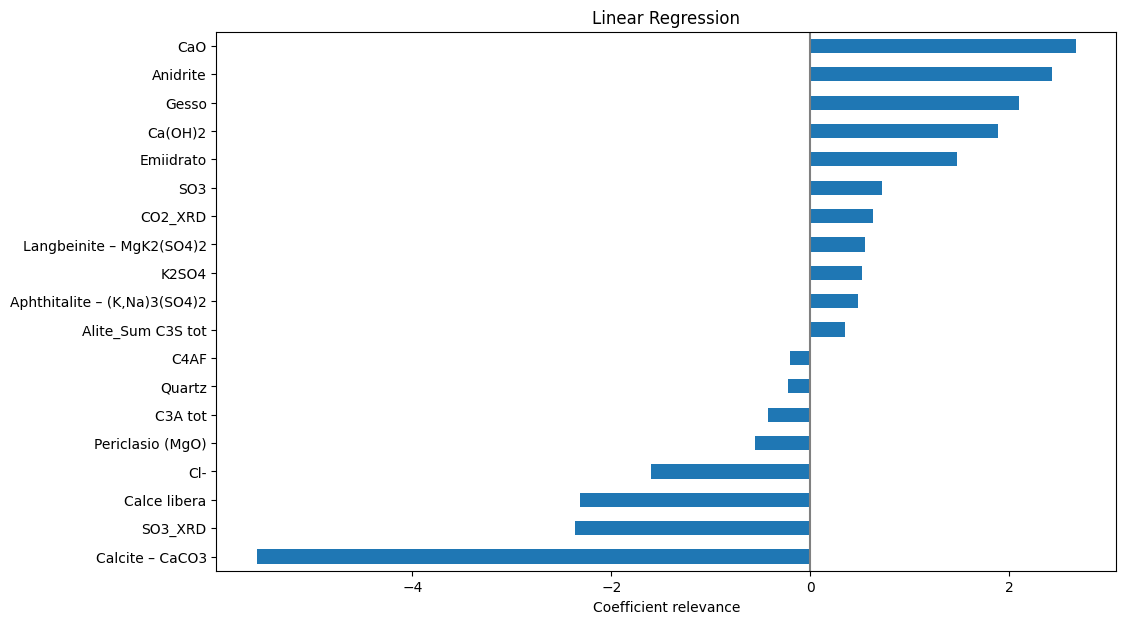

<IPython.core.display.Javascript object>

In [19]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(15, 7))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.subplots_adjust(left=0.3)

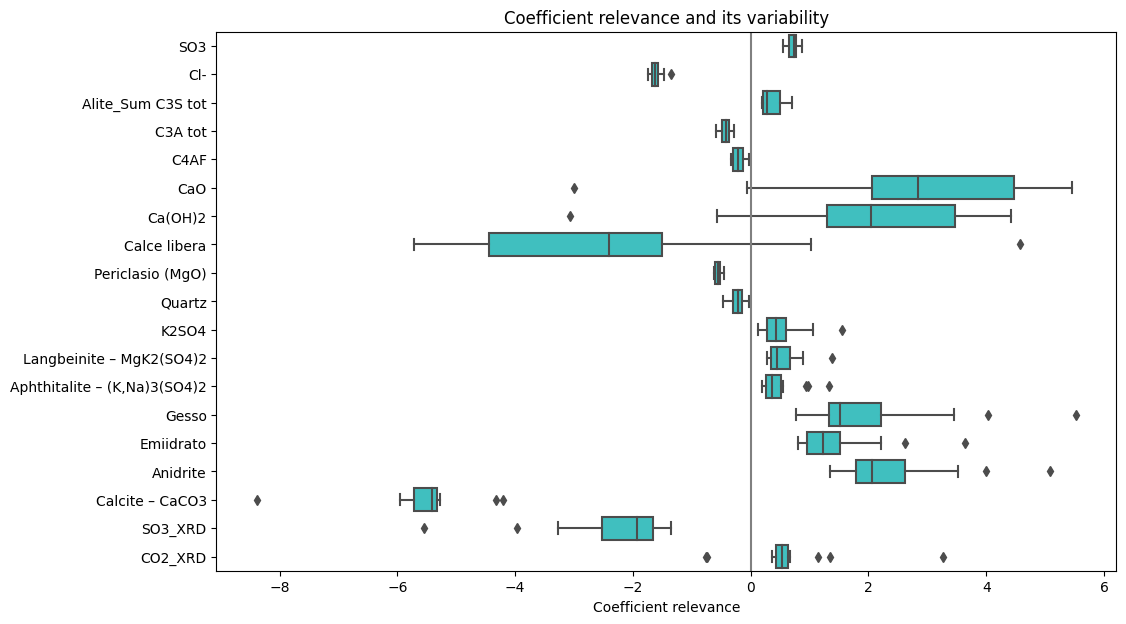

<IPython.core.display.Javascript object>

In [20]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 7))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.title("Coefficient relevance and its variability")
plt.subplots_adjust(left=0.3)

In [17]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
SO3,15.0,0.550082,0.094809,0.382410,0.501195,0.554100,0.602553,0.703983
Cl-,15.0,-1.424186,0.099126,-1.559570,-1.490528,-1.432968,-1.372014,-1.210726
Alite_M3 C3S M3,15.0,5.735953,10.209206,-6.414023,-0.805539,4.080910,9.249139,30.875055
Alite_M1 C3S M1,15.0,8.646719,8.943674,-2.935672,3.507193,7.483021,11.751855,30.810119
Alite_Sum C3S tot,15.0,-13.600372,44.312834,-109.678337,-40.682146,-1.483386,16.470972,42.084104
Ratio_M1 (rapporto M1/M3),15.0,-1.941004,0.363433,-2.402838,-2.238276,-1.989229,-1.789509,-1.108450
C3S_CS (taglia dei cristalliti C3S),15.0,0.089126,0.051058,0.002215,0.051475,0.093689,0.115679,0.171862
Belite_beta,15.0,-1.462606,10.238229,-20.880865,-8.277170,0.734016,6.347623,11.967936
C3A cub,15.0,-2.962194,2.698356,-4.856348,-4.229483,-4.018718,-2.930024,4.986426
C3A_ortho,15.0,-5.535469,4.471054,-8.753119,-7.790531,-7.229569,-5.495879,7.664501


<IPython.core.display.Javascript object>

# 1. XGBoost

In [18]:
# Modeling
from xgboost import XGBRegressor
from xgboost import plot_importance

<IPython.core.display.Javascript object>

In [19]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "XGBoost",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

In [20]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "ph2oimm",  # Maybe pH of the immersion liquid | pH (acidity or alkalinity)
        "Initial Setting Time",
        "flow",  # Maybe flow table test
        "residuo 24 micron",  # Maybe the residue left after passing the material through a sieve
        "R_wp",  # Maybe water to powder ratio
        "Soundness",
        "CS2",  # 2-day Compressive Strength
        # Removing One-Hot encoding variables
        "cem_type_CEM B",
        "cem_type_CEM C",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

In [21]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [22]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## Repeated KFold

In [23]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.883 (0.030)
MAE: -2.277 (0.024)
MAPE: -0.048 (0.001)
R2: 0.810 (0.004)


******
[TEST]
******
RMSE: -3.164 (0.145)
MAE: -2.509 (0.119)
MAPE: -0.053 (0.003)
R2: 0.770 (0.019)




<IPython.core.display.Javascript object>

   1. Weight: Reflects the number of times a feature is used to split the data across all trees.
   
   
   2. Gain: Measures the improvement in accuracy brought by a feature to the branches it is on. This is relevant for regression with squared error, as it directly reflects the reduction in the squared error.
   
   3. Cover: Represents the relative quantity of observations concerned by a feature.

https://xgboost.readthedocs.io/en/stable/python/python_api.html

https://forecastegy.com/posts/xgboost-feature-importance-python/

1. ‘weight’: the number of times a feature is used to split the data across all trees.

2.  ‘gain’: the average gain across all splits the feature is used in.

3.  ‘cover’: the average coverage across all splits the feature is used in.

4. ‘total_gain’: the total gain across all splits the feature is used in.

5.  ‘total_cover’: the total coverage across all splits the feature is used in.


In [24]:
df_importances = get_xgboost_importances(scores, importance_type="gain")

<IPython.core.display.Javascript object>

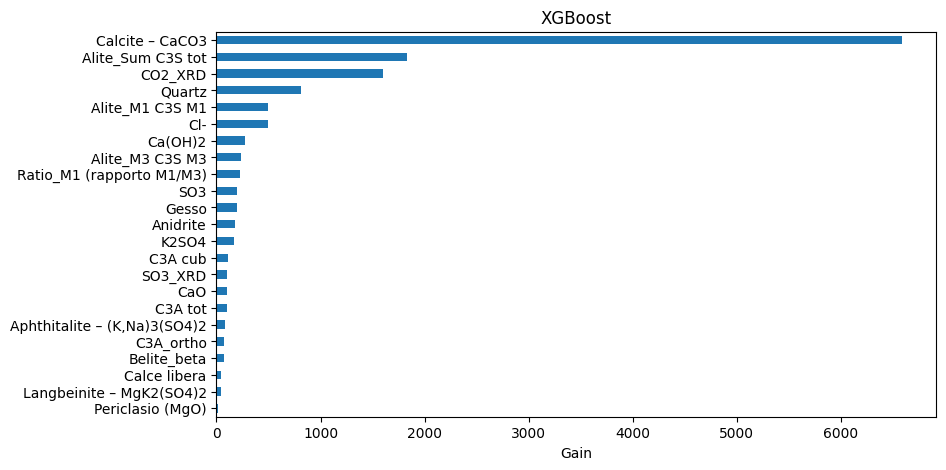

<IPython.core.display.Javascript object>

In [25]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("XGBoost")
plt.xlabel("Gain")
plt.subplots_adjust(left=0.3)

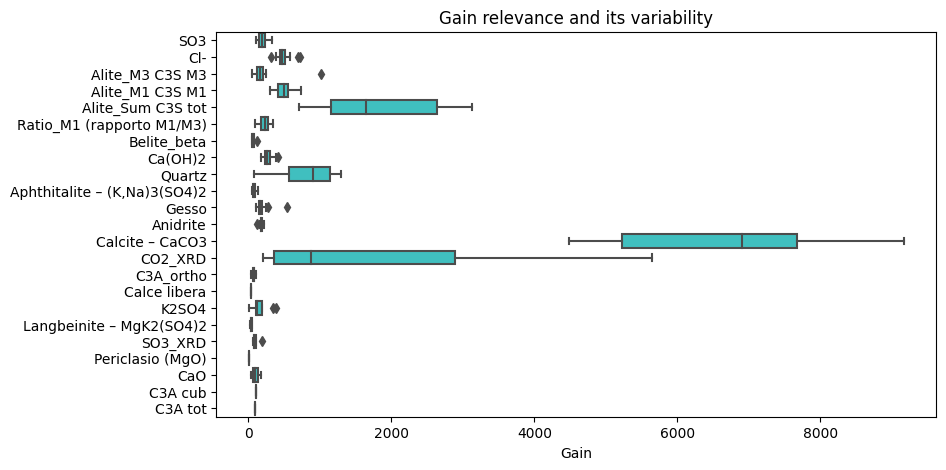

<IPython.core.display.Javascript object>

In [26]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Gain")
plt.title("Gain relevance and its variability")
plt.subplots_adjust(left=0.3)

In [27]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
SO3,15.0,198.046907,69.937139,108.744949,148.808922,189.457886,230.211311,336.849640
Cl-,15.0,491.764899,107.407151,321.635071,442.156372,468.098541,512.579391,726.546265
Alite_M3 C3S M3,10.0,239.630846,277.382597,45.745667,126.590187,166.909805,204.181850,1012.337646
Alite_M1 C3S M1,15.0,499.138511,122.474700,304.139099,420.035248,497.094482,548.189026,740.118408
Alite_Sum C3S tot,14.0,1828.789010,851.203053,715.154663,1151.288483,1648.706482,2637.207336,3131.112793
Ratio_M1 (rapporto M1/M3),5.0,225.765259,93.099563,98.277039,183.034851,228.913086,273.073975,345.527344
Belite_beta,6.0,69.634572,24.086053,47.833466,55.285782,62.816177,73.504250,114.499023
Ca(OH)2,12.0,273.041189,72.940365,180.653503,232.985138,255.320099,302.639526,412.454590
Quartz,13.0,812.783616,379.517504,85.537781,575.247375,897.642334,1136.462891,1301.613281
"Aphthitalite – (K,Na)3(SO4)2",4.0,86.236374,37.330212,53.410767,64.697296,76.274536,97.813614,138.985657


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Physical Features

In [28]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Linear Regression

## Defining Features

In this set of experiments we keep all features

In [29]:
CEM_TYPE = ["cem_type_CEM B", "cem_type_CEM C"]
df_copy = df.copy().drop(CEM_TYPE, axis=1)

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [30]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation


In [31]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.171 (0.020)
MAE: -1.688 (0.018)
MAPE: -0.035 (0.000)
R2: 0.892 (0.002)


******
[TEST]
******
RMSE: -2.289 (0.099)
MAE: -1.773 (0.067)
MAPE: -0.037 (0.001)
R2: 0.879 (0.010)




<IPython.core.display.Javascript object>

In [32]:
df_coefs, df_bias = get_linreg_df_importances(scores)

<IPython.core.display.Javascript object>

In [33]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
Alite_M3 C3S M3,-5.918450
Alite_M1 C3S M1,-4.368250
CaO,-1.473305
Cl-,-1.115366
Ca(OH)2,-0.588885
residuo 24 micron,-0.427793
Blaine,-0.391738
SO3,-0.258076
CO2_XRD,-0.223094
C3S_CS (taglia dei cristalliti C3S),0.000999


<IPython.core.display.Javascript object>

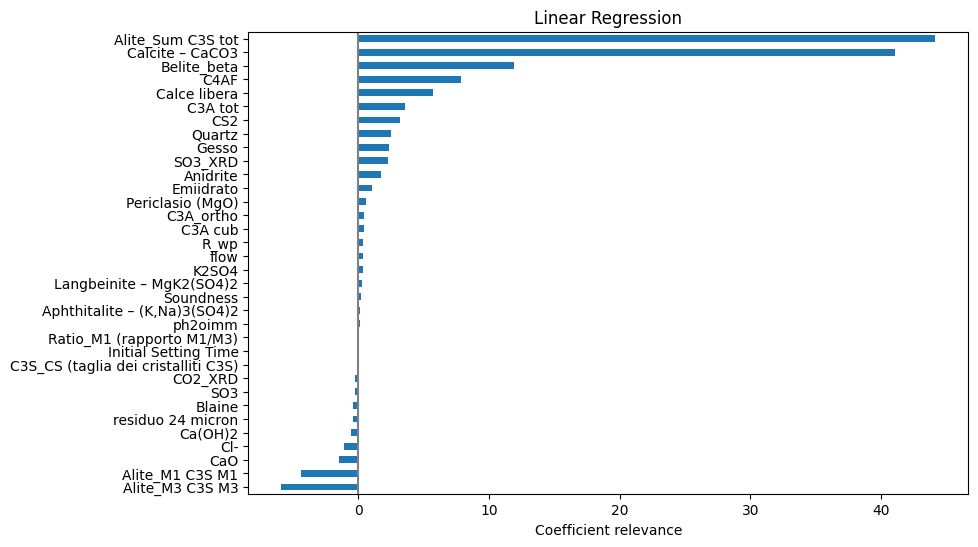

<IPython.core.display.Javascript object>

In [35]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 6))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.subplots_adjust(left=0.3)

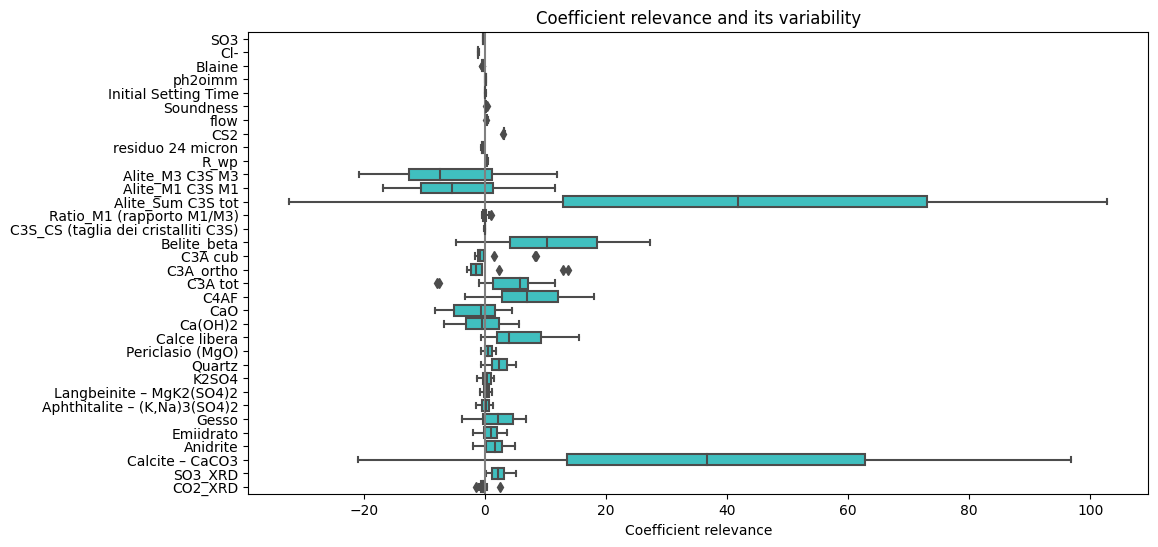

<IPython.core.display.Javascript object>

In [36]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 6))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.title("Coefficient relevance and its variability")
plt.subplots_adjust(left=0.3)

In [36]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
SO3,15.0,-0.258076,0.065590,-0.368585,-0.294722,-0.263772,-0.223643,-0.124330
Cl-,15.0,-1.115366,0.055815,-1.211760,-1.153676,-1.107402,-1.068420,-1.037481
Blaine,15.0,-0.391738,0.048273,-0.490963,-0.405527,-0.393056,-0.366970,-0.315996
ph2oimm,15.0,0.136622,0.059859,0.040484,0.094322,0.138329,0.179683,0.238352
Initial Setting Time,15.0,0.046071,0.048528,-0.059158,0.018629,0.067063,0.087445,0.096856
Soundness,15.0,0.192684,0.037429,0.118230,0.177269,0.191498,0.207763,0.278941
flow,15.0,0.358519,0.057115,0.218996,0.328238,0.370616,0.394168,0.440674
CS2,15.0,3.179649,0.089624,2.951365,3.135070,3.194695,3.230123,3.307357
residuo 24 micron,15.0,-0.427793,0.088948,-0.598535,-0.514416,-0.414593,-0.357995,-0.311963
R_wp,15.0,0.368408,0.064332,0.242948,0.336431,0.371201,0.410129,0.466872


<IPython.core.display.Javascript object>

# XGBoost

## Defining a dataframe structure to save the results

In [37]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "XGBoost",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [38]:
df_copy = df.copy().drop(CEM_TYPE, axis=1)

<IPython.core.display.Javascript object>

In [39]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [40]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [41]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.441 (0.029)
MAE: -1.942 (0.022)
MAPE: -0.040 (0.000)
R2: 0.864 (0.003)


******
[TEST]
******
RMSE: -2.686 (0.133)
MAE: -2.129 (0.081)
MAPE: -0.044 (0.002)
R2: 0.834 (0.016)




<IPython.core.display.Javascript object>

In [42]:
df_importances = get_xgboost_importances(scores, importance_type="gain")

<IPython.core.display.Javascript object>

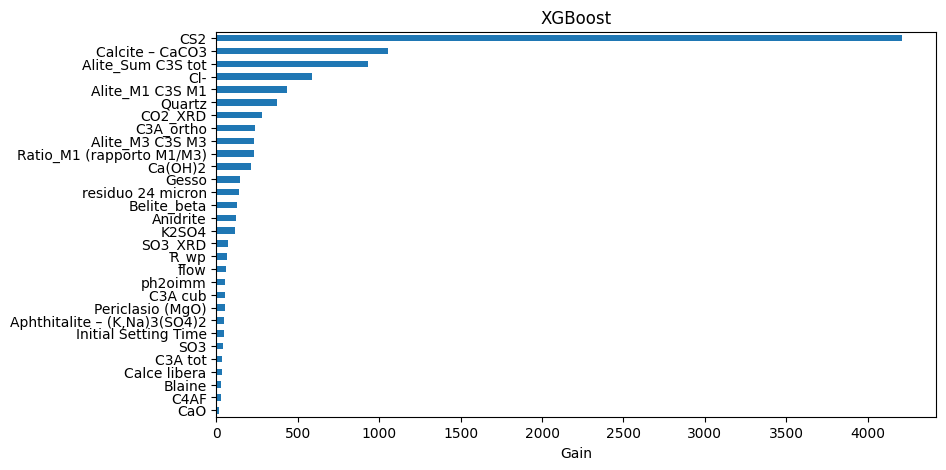

<IPython.core.display.Javascript object>

In [43]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("XGBoost")
plt.xlabel("Gain")
plt.subplots_adjust(left=0.3)

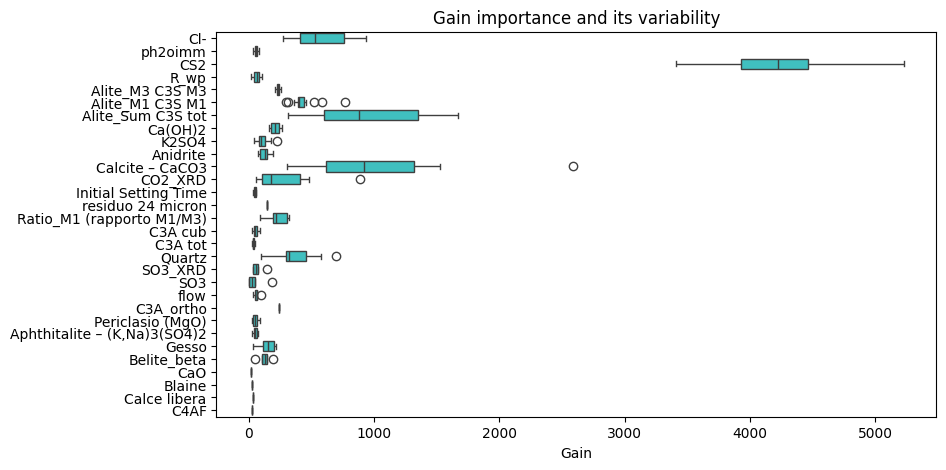

<IPython.core.display.Javascript object>

In [44]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Gain")
plt.title("Gain importance and its variability")
plt.subplots_adjust(left=0.3)

In [45]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
Cl-,15.0,586.241659,220.112276,275.021667,407.942352,527.422241,761.798096,934.656860
ph2oimm,4.0,55.310336,19.947838,31.082348,44.656131,56.154079,66.808285,77.850838
CS2,15.0,4212.021370,482.598969,3411.066650,3930.493774,4225.493164,4467.322998,5229.322754
R_wp,9.0,61.652315,28.468268,17.687469,43.491127,63.006065,76.318932,104.748100
Alite_M3 C3S M3,2.0,232.640198,30.359239,211.172974,221.906586,232.640198,243.373810,254.107422
Alite_M1 C3S M1,15.0,433.424996,116.209604,296.701660,393.822189,396.716309,441.134003,768.395752
Alite_Sum C3S tot,14.0,932.534716,439.990670,310.199097,597.037537,875.958862,1350.042999,1666.103516
Ca(OH)2,4.0,211.733055,47.896234,159.586212,178.998253,211.142303,243.877106,265.061401
K2SO4,11.0,112.679281,51.547207,42.905182,76.497345,99.034058,128.725586,222.562378
Anidrite,11.0,122.860279,39.785741,68.754349,91.513245,127.628822,146.471680,194.464661


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Cement Type

# Linear Regression

## Defining a dataframe structure to save the results

In [46]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [47]:
df_copy = df.copy()
df_copy[CEM_TYPE] = df_copy[CEM_TYPE].astype(int)
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "ph2oimm",  # Maybe pH of the immersion liquid | pH (acidity or alkalinity)
        "Initial Setting Time",
        "flow",  # Maybe flow table test
        "residuo 24 micron",  # Maybe the residue left after passing the material through a sieve
        "R_wp",  # Maybe water to powder ratio
        "Soundness",
        "CS2",  # 2-day Compressive Strength
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [48]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [49]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.413 (0.022)
MAE: -1.950 (0.022)
MAPE: -0.040 (0.000)
R2: 0.867 (0.003)


******
[TEST]
******
RMSE: -2.503 (0.088)
MAE: -2.026 (0.072)
MAPE: -0.042 (0.002)
R2: 0.856 (0.011)




<IPython.core.display.Javascript object>

In [50]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_coefs = df_coefs.rename(
    {
        "cem_type_CEM B": "Cem Type A",
        "cem_type_CEM C": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

In [51]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
Cem Type B,-5.089469
Calce libera,-4.900348
Alite_M3 C3S M3,-3.548971
C3A_ortho,-3.508814
C3A cub,-1.806529
Calcite – CaCO3,-1.269791
Cem Type A,-0.872753
Alite_M1 C3S M1,-0.813327
Ratio_M1 (rapporto M1/M3),-0.643633
SO3_XRD,-0.626462


<IPython.core.display.Javascript object>

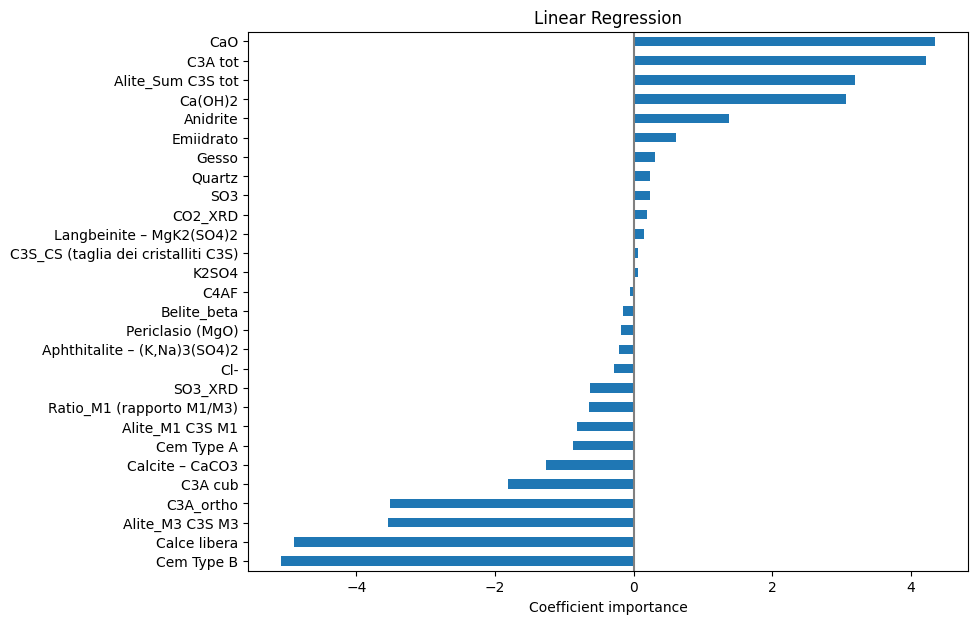

<IPython.core.display.Javascript object>

In [52]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 7))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

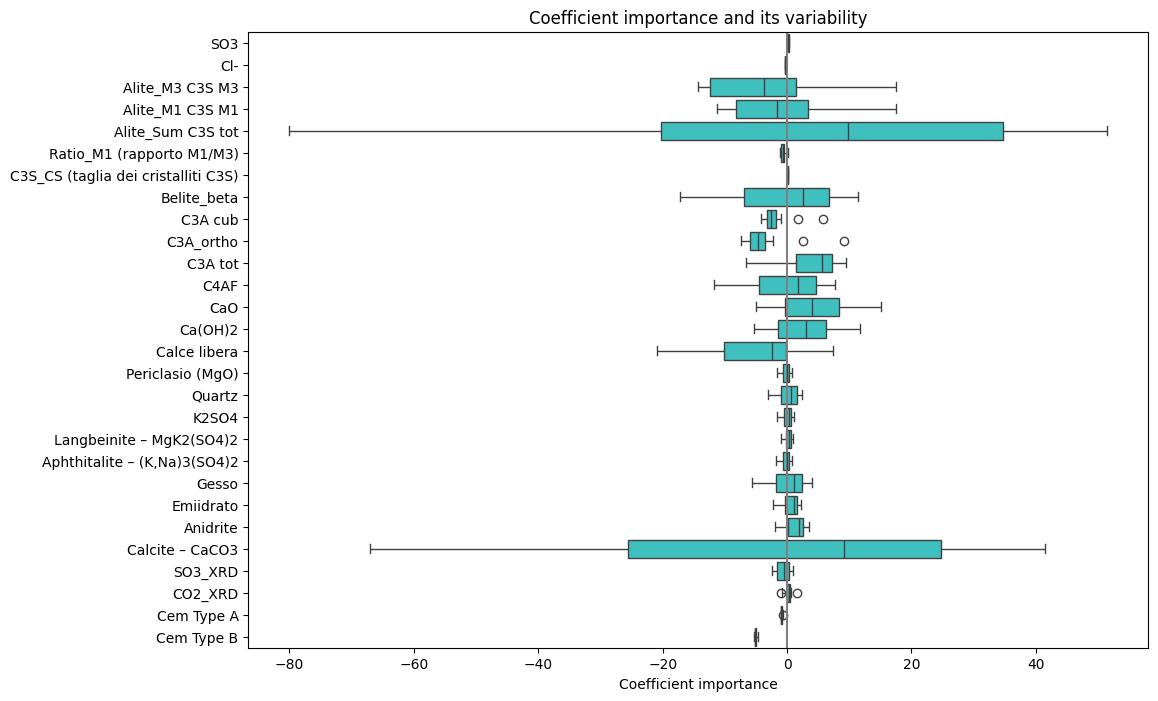

<IPython.core.display.Javascript object>

In [53]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

In [54]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
SO3,15.0,0.231889,0.082133,0.109518,0.171177,0.221940,0.296122,0.366855
Cl-,15.0,-0.287325,0.067861,-0.392837,-0.347417,-0.273793,-0.239752,-0.159572
Alite_M3 C3S M3,15.0,-3.548971,9.473446,-14.376191,-12.444778,-3.727540,1.424320,17.552519
Alite_M1 C3S M1,15.0,-0.813327,8.329761,-11.308424,-8.277195,-1.562983,3.395523,17.523886
Alite_Sum C3S tot,15.0,3.194947,40.329109,-80.038030,-20.286525,9.770918,34.655652,51.474527
Ratio_M1 (rapporto M1/M3),15.0,-0.643633,0.365518,-1.079866,-0.939011,-0.635058,-0.455765,0.206992
C3S_CS (taglia dei cristalliti C3S),15.0,0.069717,0.035872,-0.010761,0.046125,0.076502,0.086794,0.117836
Belite_beta,15.0,-0.150697,9.320119,-17.285652,-6.982415,2.637592,6.671389,11.434584
C3A cub,15.0,-1.806529,2.544958,-4.183353,-3.241853,-2.509227,-1.847883,5.824229
C3A_ortho,15.0,-3.508814,4.224787,-7.444829,-5.958428,-4.656827,-3.554221,9.212550


<IPython.core.display.Javascript object>

# Random Forest

## Defining a dataframe structure to save the results

In [55]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [56]:
df_copy = df.copy()
df_copy[CEM_TYPE] = df_copy[CEM_TYPE].astype(int)
df_copy = df_copy.drop(
    [
        # Properties
        "Blaine",
        "ph2oimm",  # Maybe pH of the immersion liquid | pH (acidity or alkalinity)
        "Initial Setting Time",
        "flow",  # Maybe flow table test
        "residuo 24 micron",  # Maybe the residue left after passing the material through a sieve
        "R_wp",  # Maybe water to powder ratio
        "Soundness",
        "CS2",  # 2-day Compressive Strength
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [57]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [58]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [59]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.430 (0.032)
MAE: -1.972 (0.030)
MAPE: -0.041 (0.001)
R2: 0.865 (0.004)


******
[TEST]
******
RMSE: -2.626 (0.111)
MAE: -2.131 (0.088)
MAPE: -0.044 (0.002)
R2: 0.841 (0.015)




<IPython.core.display.Javascript object>

In [60]:
df_importances = get_random_forest_df_importances(scores)
df_importances = df_importances.rename(
    {
        "cem_type_CEM B": "Cem Type A",
        "cem_type_CEM C": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

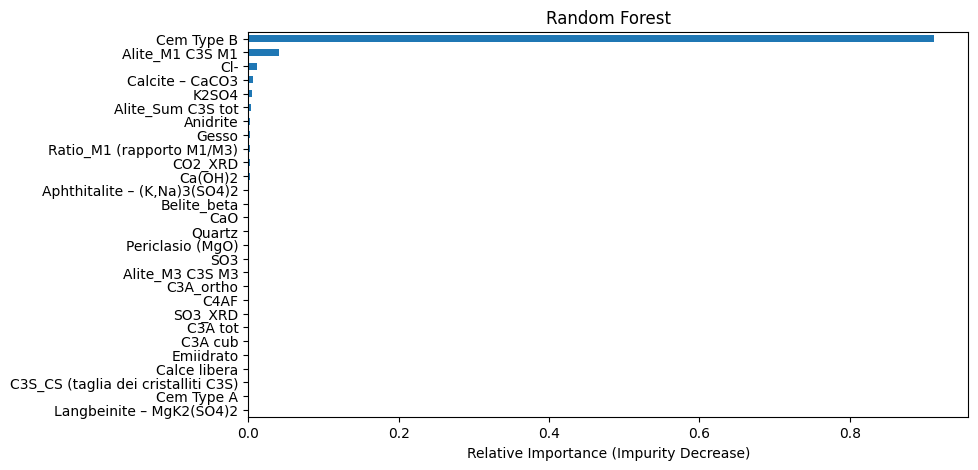

<IPython.core.display.Javascript object>

In [61]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("Random Forest")
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.subplots_adjust(left=0.3)

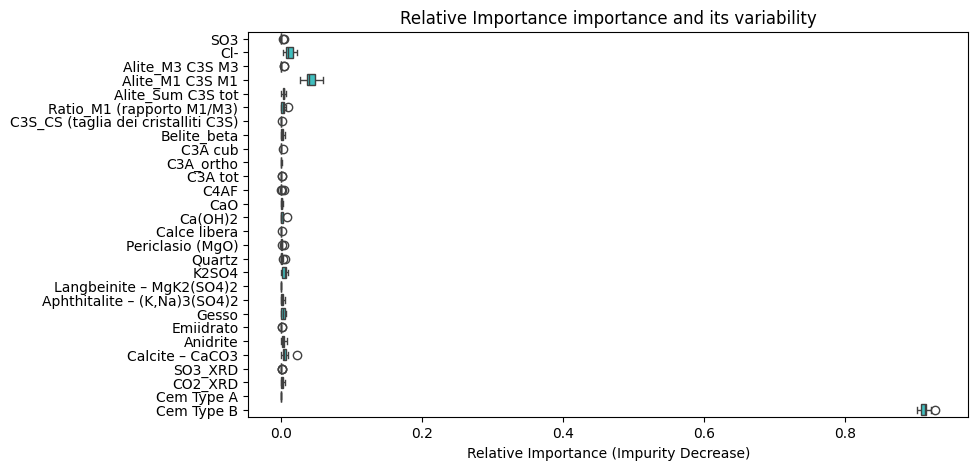

<IPython.core.display.Javascript object>

In [62]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.title("Relative Importance importance and its variability")
plt.subplots_adjust(left=0.3)

In [63]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
SO3,15.0,0.000560,0.001265,0.000000,0.000000,0.000000,0.000292,0.004115
Cl-,15.0,0.011843,0.006406,0.003128,0.007003,0.010055,0.016492,0.023327
Alite_M3 C3S M3,15.0,0.000541,0.001430,0.000000,0.000000,0.000000,0.000000,0.004173
Alite_M1 C3S M1,15.0,0.040967,0.009411,0.027541,0.036871,0.039703,0.047854,0.059137
Alite_Sum C3S tot,15.0,0.003625,0.002223,0.000000,0.002455,0.004133,0.004638,0.007735
Ratio_M1 (rapporto M1/M3),15.0,0.002854,0.002822,0.000000,0.000338,0.002354,0.003723,0.009519
C3S_CS (taglia dei cristalliti C3S),15.0,0.000069,0.000268,0.000000,0.000000,0.000000,0.000000,0.001038
Belite_beta,15.0,0.001516,0.001521,0.000000,0.000000,0.001362,0.002514,0.005041
C3A cub,15.0,0.000167,0.000646,0.000000,0.000000,0.000000,0.000000,0.002502
C3A_ortho,15.0,0.000318,0.000446,0.000000,0.000000,0.000000,0.000595,0.001314


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Physical + Cement Type

# Linear Regression

## Defining a dataframe structure to save the results

In [64]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical + Physical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining the Features

In [65]:
df_copy = df.copy()
df_copy[CEM_TYPE] = df_copy[CEM_TYPE].astype(int)

<IPython.core.display.Javascript object>

In [66]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [67]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.069 (0.018)
MAE: -1.615 (0.017)
MAPE: -0.033 (0.000)
R2: 0.902 (0.002)


******
[TEST]
******
RMSE: -2.182 (0.084)
MAE: -1.704 (0.059)
MAPE: -0.035 (0.001)
R2: 0.890 (0.008)




<IPython.core.display.Javascript object>

In [68]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_coefs = df_coefs.rename(
    {
        "cem_type_CEM B": "Cem Type A",
        "cem_type_CEM C": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

In [69]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
Alite_M3 C3S M3,-4.599444
Alite_M1 C3S M1,-3.210686
Cem Type B,-2.672207
C3A_ortho,-0.984484
Cem Type A,-0.650408
Cl-,-0.590880
C3A cub,-0.369728
residuo 24 micron,-0.343412
Blaine,-0.195734
"Aphthitalite – (K,Na)3(SO4)2",-0.141839


<IPython.core.display.Javascript object>

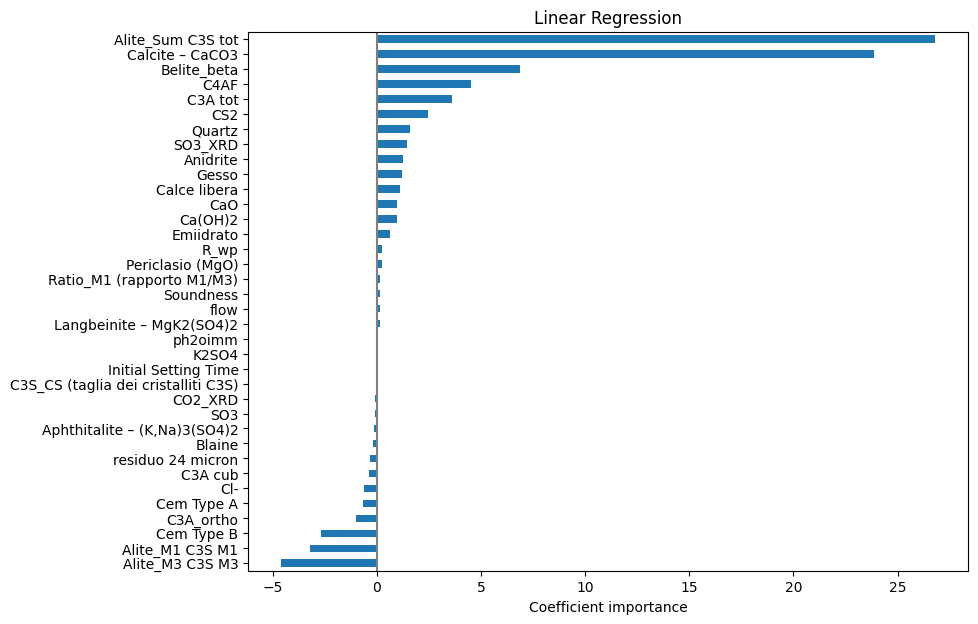

<IPython.core.display.Javascript object>

In [70]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 7))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

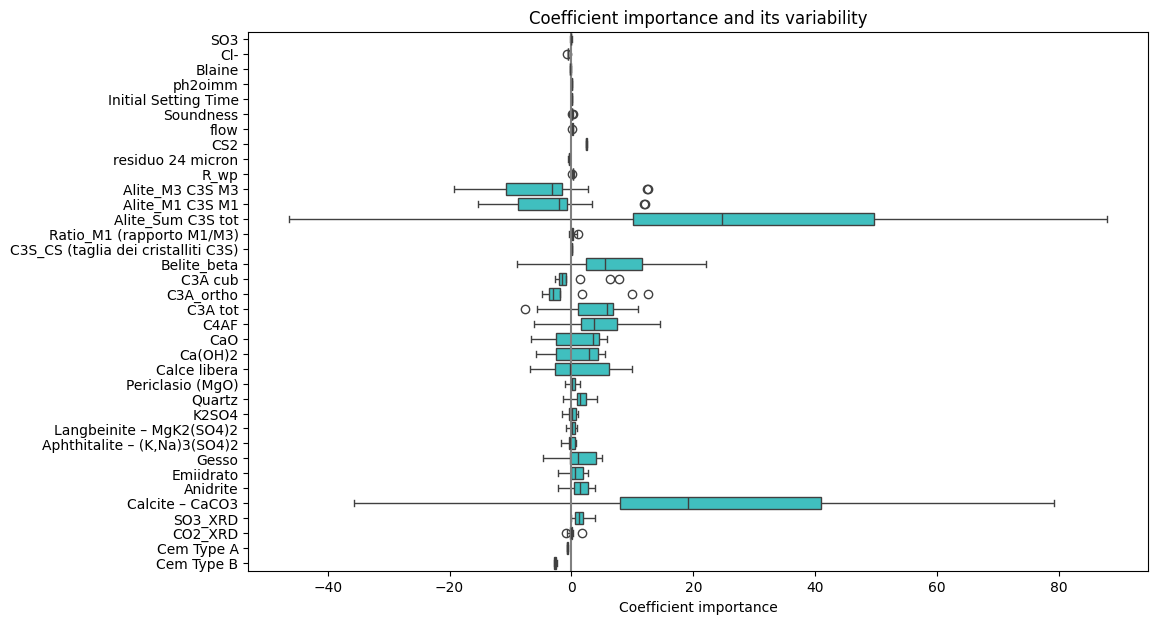

<IPython.core.display.Javascript object>

In [71]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 7))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

In [72]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
SO3,15.0,-0.088958,0.086483,-0.214971,-0.154660,-0.093148,-0.050739,0.062572
Cl-,15.0,-0.590880,0.058416,-0.738417,-0.615872,-0.586932,-0.563340,-0.489809
Blaine,15.0,-0.195734,0.050619,-0.300766,-0.215450,-0.191150,-0.155834,-0.130042
ph2oimm,15.0,0.037095,0.062368,-0.073934,0.005530,0.026115,0.089908,0.131094
Initial Setting Time,15.0,0.032763,0.044909,-0.053240,0.005379,0.049066,0.071038,0.078754
Soundness,15.0,0.152140,0.029603,0.089737,0.140047,0.157388,0.164499,0.212520
flow,15.0,0.149021,0.052808,0.025853,0.122310,0.161534,0.180557,0.225239
CS2,15.0,2.477407,0.085325,2.326053,2.420087,2.465106,2.548478,2.605584
residuo 24 micron,15.0,-0.343412,0.088487,-0.511953,-0.413247,-0.328576,-0.266793,-0.238205
R_wp,15.0,0.261497,0.068680,0.113059,0.229091,0.272102,0.303968,0.366959


<IPython.core.display.Javascript object>

# Random Forest

## Defining a dataframe structure to save the results

In [73]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical + CS2 + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [74]:
df_copy = df.copy()
df_copy[CEM_TYPE] = df_copy[CEM_TYPE].astype(int)
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "ph2oimm",  # Maybe pH of the immersion liquid | pH (acidity or alkalinity)
        "Initial Setting Time",
        "flow",  # Maybe flow table test
        "residuo 24 micron",  # Maybe the residue left after passing the material through a sieve
        "R_wp",  # Maybe water to powder ratio
        "Soundness",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

In [75]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [76]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

## 1.1. Repeated KFold Cross validation

In [77]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.279 (0.032)
MAE: -1.793 (0.035)
MAPE: -0.037 (0.001)
R2: 0.881 (0.004)


******
[TEST]
******
RMSE: -2.457 (0.113)
MAE: -1.941 (0.082)
MAPE: -0.040 (0.002)
R2: 0.861 (0.016)




<IPython.core.display.Javascript object>

In [78]:
df_importances = get_random_forest_df_importances(scores)
df_importances = df_importances.rename(
    {
        "cem_type_CEM B": "Cem Type A",
        "cem_type_CEM C": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

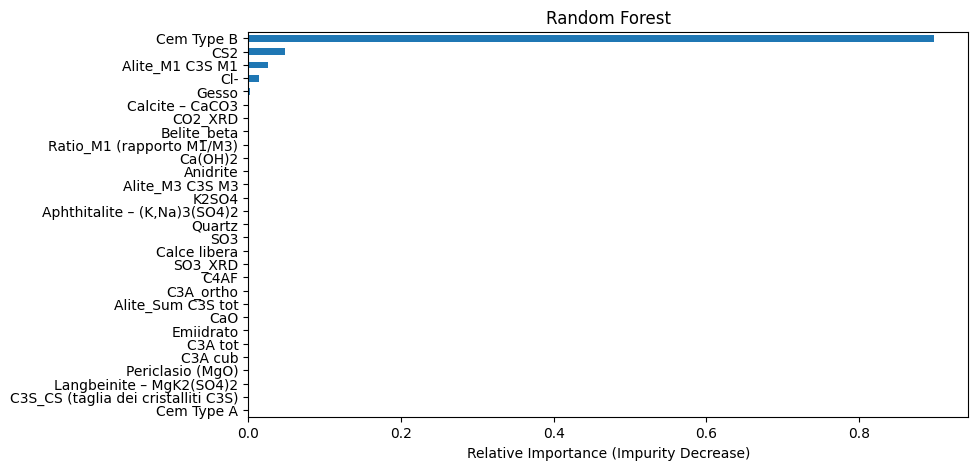

<IPython.core.display.Javascript object>

In [79]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("Random Forest")
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.subplots_adjust(left=0.3)

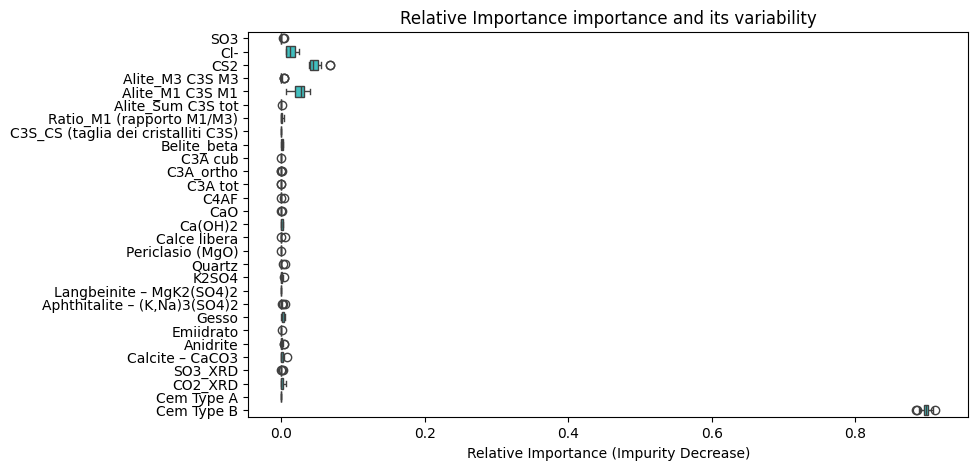

<IPython.core.display.Javascript object>

In [80]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.title("Relative Importance importance and its variability")
plt.subplots_adjust(left=0.3)

In [81]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
SO3,15.0,0.000474,0.001267,0.000000,0.000000,0.000000,0.000000,0.004086
Cl-,15.0,0.013559,0.006278,0.006641,0.007552,0.012429,0.018985,0.025247
CS2,15.0,0.047545,0.010086,0.039363,0.040060,0.044650,0.050963,0.068918
Alite_M3 C3S M3,15.0,0.000890,0.001642,0.000000,0.000000,0.000000,0.000698,0.004146
Alite_M1 C3S M1,15.0,0.026182,0.009737,0.007642,0.019724,0.027956,0.032180,0.040292
Alite_Sum C3S tot,15.0,0.000117,0.000452,0.000000,0.000000,0.000000,0.000000,0.001750
Ratio_M1 (rapporto M1/M3),15.0,0.001146,0.001448,0.000000,0.000000,0.000000,0.002116,0.004161
C3S_CS (taglia dei cristalliti C3S),15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Belite_beta,15.0,0.001305,0.001346,0.000000,0.000000,0.000910,0.002744,0.003256
C3A cub,15.0,0.000033,0.000129,0.000000,0.000000,0.000000,0.000000,0.000500


<IPython.core.display.Javascript object>